In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
import os
from sklearn.metrics import davies_bouldin_score
import numpy as np


In [114]:
# Loading and reading the files
customers_path = open(os.path.expanduser("~/Desktop/Customers.csv"))
products_path = open(os.path.expanduser("~/Desktop/Products.csv"))
transactions_path = open(os.path.expanduser("~/Desktop/Transactions.csv"))


customers_df = pd.read_csv(customers_path)
products_df = pd.read_csv(products_path)
transactions_df = pd.read_csv(transactions_path)

In [115]:
# Merging the files
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'], errors='coerce')
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'], errors='coerce')

merged_df = transactions_df.merge(customers_df, on='CustomerID', how='left').merge(products_df, on='ProductID', how='left')

merged_df = merged_df.drop(columns=['Price_x']).rename(columns={'Price_y': 'Price'})

/var/folders/n6/dg3632bd7t39bt9vx_5h9z3r0000gn/T/ipykernel_89219/680270663.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, y="Region", order=merged_df["Region"].value_counts().index, palette="pastel")


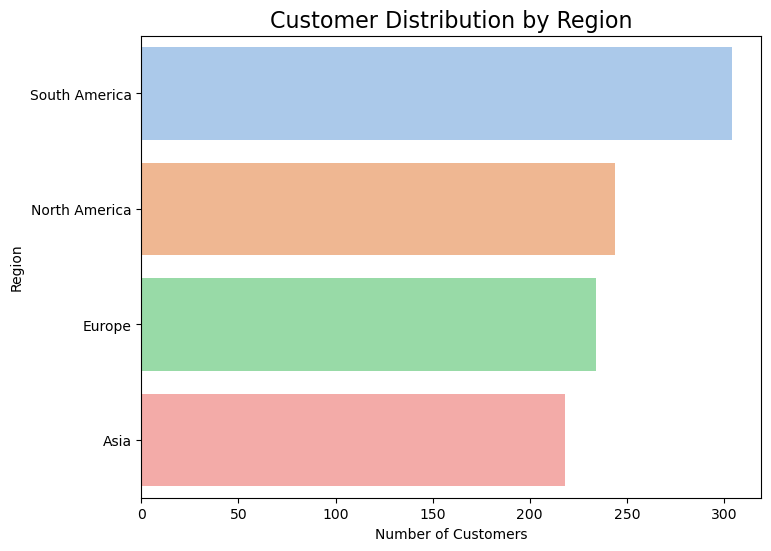

In [116]:
# Exploratory Data Analysis

# Checking the Customers by region 
plt.figure(figsize=(8, 6))
sns.countplot(data=merged_df, y="Region", order=merged_df["Region"].value_counts().index, palette="pastel")
plt.title("Customer Distribution by Region", fontsize=16)
plt.xlabel("Number of Customers")
plt.ylabel("Region")
plt.savefig('customer_distribution_by_region.png')
plt.show()

/var/folders/n6/dg3632bd7t39bt9vx_5h9z3r0000gn/T/ipykernel_89219/1453079942.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=merged_df, x="Category", y="TotalValue", estimator=sum, palette="muted", ci=None)
/var/folders/n6/dg3632bd7t39bt9vx_5h9z3r0000gn/T/ipykernel_89219/1453079942.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_df, x="Category", y="TotalValue", estimator=sum, palette="muted", ci=None)


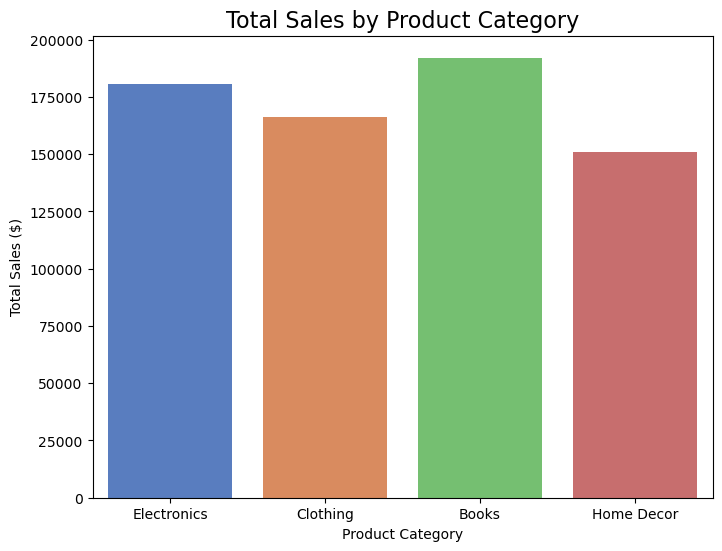

In [117]:
# Sales Performance 
plt.figure(figsize=(8, 6))
sns.barplot(data=merged_df, x="Category", y="TotalValue", estimator=sum, palette="muted", ci=None)
plt.title("Total Sales by Product Category", fontsize=16)
plt.xlabel("Product Category")
plt.ylabel("Total Sales ($)")
plt.savefig('sales_by_product_category.png')
plt.show()

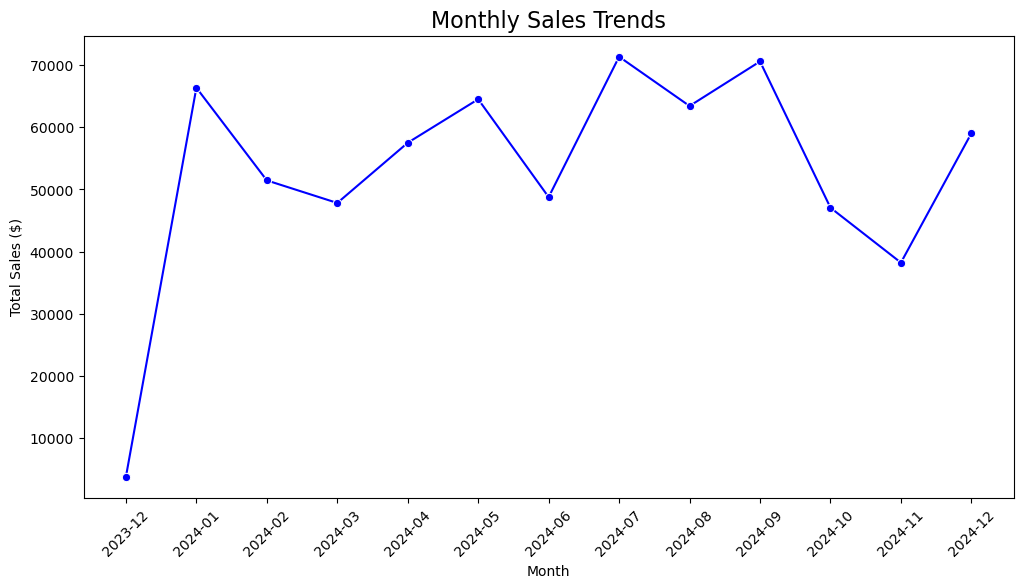

In [118]:
# Monthly Transactions 
merged_df['Month'] = merged_df['TransactionDate'].dt.to_period('M')
monthly_sales = merged_df.groupby('Month')['TotalValue'].sum().reset_index()
monthly_sales['Month'] = monthly_sales['Month'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x="Month", y="TotalValue", marker="o", color="b")
plt.title("Monthly Sales Trends", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Total Sales ($)")
plt.xticks(rotation=45)
plt.savefig('monthly_sales_trends.png')
plt.show()


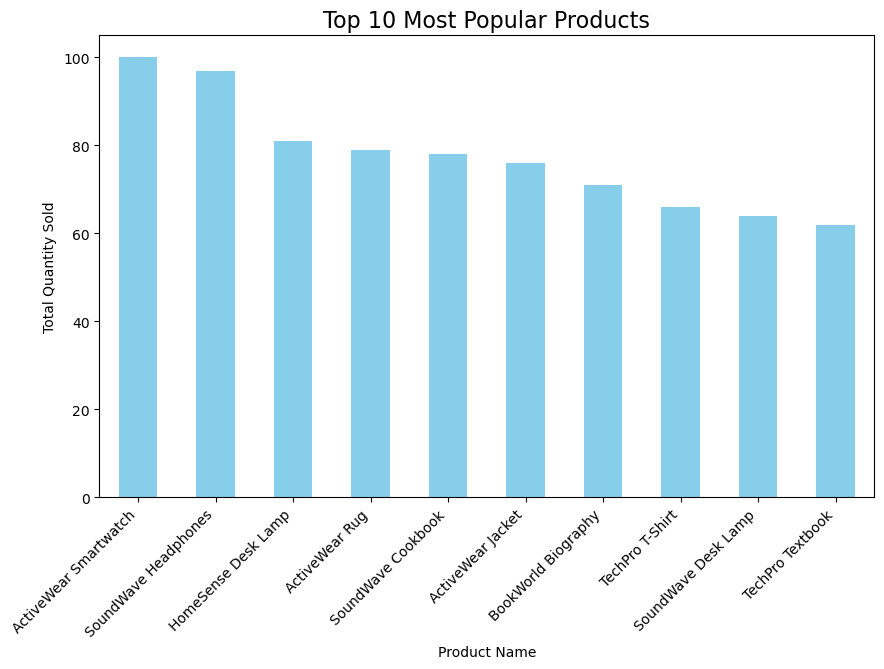

In [119]:
# 4. Product Popularity
popular_products = merged_df.groupby('ProductName')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
popular_products.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Popular Products', fontsize=16)
plt.xlabel('Product Name')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45, ha='right')
plt.savefig('top_10_popular_products.png')
plt.show()

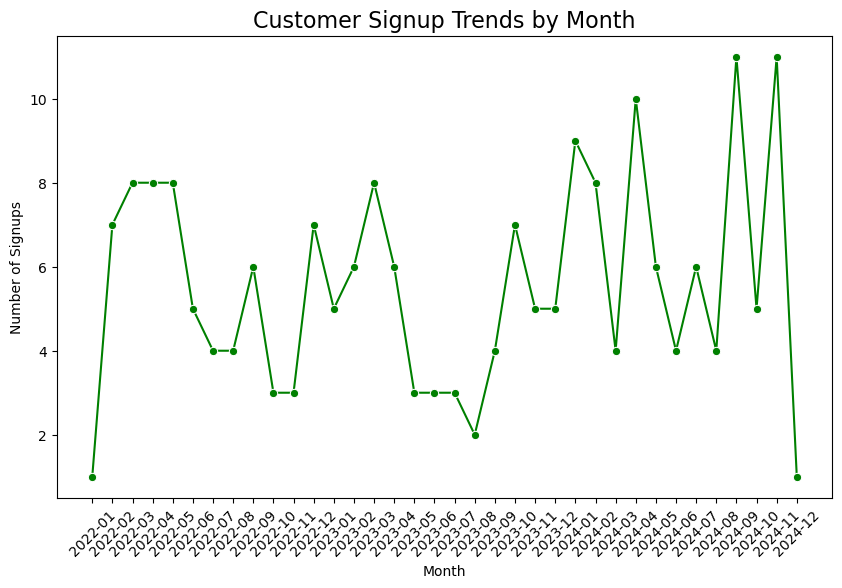

In [120]:
# 5. Signups monthly
customers_df['SignupMonth'] = customers_df['SignupDate'].dt.to_period('M')
signup_trends = customers_df.groupby('SignupMonth')['CustomerID'].count().reset_index()
signup_trends['SignupMonth'] = signup_trends['SignupMonth'].astype(str)

plt.figure(figsize=(10, 6))
sns.lineplot(data=signup_trends, x="SignupMonth", y="CustomerID", marker="o", color="green")
plt.title("Customer Signup Trends by Month", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Number of Signups")
plt.xticks(rotation=45)
plt.savefig('signup_trends.png')
plt.show()

In [121]:
# Lookalike Model

customer_features = merged_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'ProductID': lambda x: x.nunique(),
    'Category': lambda x: ','.join(x.unique()),
    'Region': 'first'
}).reset_index()

In [122]:
# Encoding the categorical variables
encoder = OneHotEncoder()
encoded_region = encoder.fit_transform(customer_features[['Region']]).toarray()
encoded_categories = encoder.fit_transform(customer_features[['Category']]).toarray()


In [123]:
# Combine features
scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features[['TotalValue', 'Quantity', 'ProductID']])
customer_features_combined = np.hstack([customer_features_scaled, encoded_region, encoded_categories])
similarity_matrix = cosine_similarity(customer_features_combined)

In [124]:
# lookalike for first 20 Customers
lookalike_map = {}
customer_ids = customer_features['CustomerID'].values[:20]
for idx, cust_id in enumerate(customer_ids):
    similarity_scores = similarity_matrix[idx]
    similar_customers = [(customer_features['CustomerID'].values[i], similarity_scores[i])
                         for i in np.argsort(similarity_scores)[::-1] if i != idx]
    lookalike_map[cust_id] = similar_customers[:3]


In [125]:
# Making a csv file
lookalike_df = pd.DataFrame({
    'CustomerID': list(lookalike_map.keys()),
    'Lookalikes': [str([(x[0], round(x[1], 3)) for x in lookalike_map[cust_id]]) for cust_id in lookalike_map.keys()]
})
lookalike_df.to_csv('Lookalike.csv', index=False)

print("Lookalike model generated and saved as Lookalike.csv.")

Lookalike model generated and saved as Lookalike.csv.


In [126]:
# Customer Segmentation
# KMeans Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features_combined)

db_index = davies_bouldin_score(customer_features_combined, customer_features['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 2.080767181044441


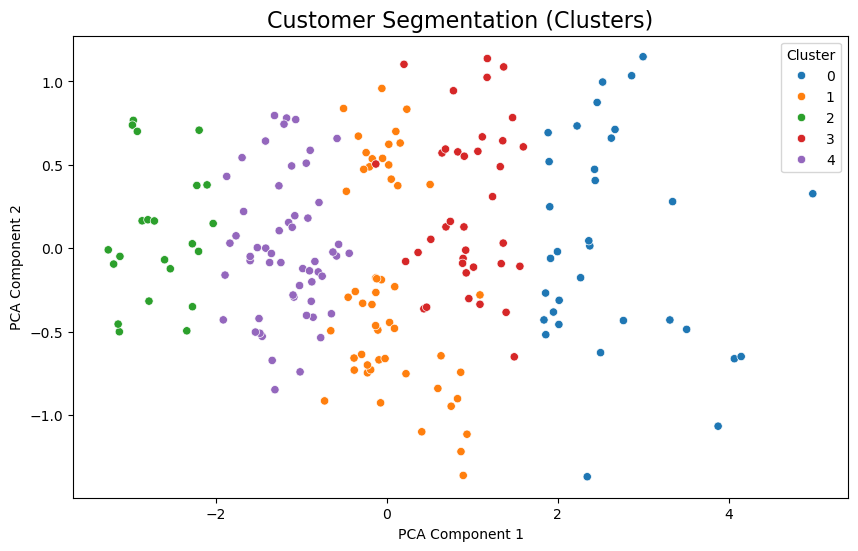

In [127]:
# Visualising Clusters (using PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
customer_features_pca = pca.fit_transform(customer_features_combined)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=customer_features_pca[:, 0], y=customer_features_pca[:, 1], 
                hue=customer_features['Cluster'], palette='tab10')
plt.title("Customer Segmentation (Clusters)", fontsize=16)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.savefig('customer_segmentation_clusters.png')
plt.show()



In [128]:
# nSave Cluster file 
customer_features[['CustomerID', 'Cluster']].to_csv('Customer_Clusters.csv', index=False)
print("Customer segmentation completed and saved as Customer_Clusters.csv.")

Customer segmentation completed and saved as Customer_Clusters.csv.


In [129]:
import os
print("Current Working Directory:", os.getcwd())


Current Working Directory: /Users/mananrasool


In [130]:
lookalike_df.to_csv('./Lookalike.csv', index=False)
customer_features[['CustomerID', 'Cluster']].to_csv('./Customer_Clusters.csv', index=False)


In [131]:
from IPython.display import FileLink
FileLink('./Customer_Clusters.csv')


/Users/mananrasool/Customer_Clusters.csv

In [132]:
FileLink('./Lookalike.csv')

/Users/mananrasool/Lookalike.csv